In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import copy
import tqdm
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
# import dataset
transform = torchvision.transforms.ToTensor() # feel free to modify this as you see fit.

training_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

validation_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

In [35]:
labels_dict = {
0 : "T-shirt/top",
1 : "Trouser",
2 :	"Pullover",
3 :	"Dress",
4 :	"Coat",
5 :	"Sandal",
6 :	"Shirt",
7 :	"Sneaker",
8 :	"Bag",
9 :	"Ankle boot"
}


Text(0.5, 1.0, 'ground truth label: 5 : Sandal')

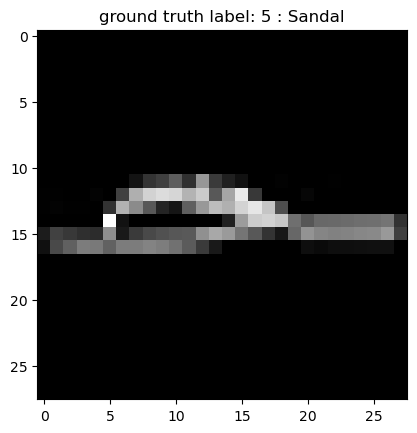

In [140]:
f = 8
test_img = validation_data[f][0][0]
test_img_label = validation_data[f][1]
plt.imshow(test_img, cmap='gray')
plt.title("ground truth label: " +str(test_img_label) + " : " + labels_dict[test_img_label])

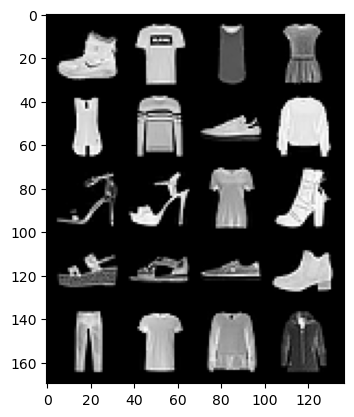

In [141]:
# let's take a look at the sample images
images = [training_data[i][0] for i in range(20)]
plt.imshow(torchvision.utils.make_grid(torch.stack(images), nrow=4, padding=5).numpy().transpose((1, 2, 0)))

In [23]:
class MLP(nn.Module):
    def __init__(self, input_units, hidden_units, output_units):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Linear(input_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_units)
        ).to(device)

    def forward(self, X):
        return self.layer_stack(X)

In [89]:
## Define Model
# if pretrained weights available, load those
model_0 = MLP(784, 256, 10)
weight_pth = 'torch_weights/fashion_mnist_mlp.pt'
train_required = False
if os.path.exists(weight_pth):
    print("loading pre-trained weights from path: " + str(weight_pth))
    state_dict = torch.load(weight_pth,map_location=device)
    model_0.load_state_dict(state_dict)
    model_0.eval()
else:
    train_required = True
    # if training required, upload training loop below and run

loading pre-trained weights from path: torch_weights/fashion_mnist_mlp.pt


In [90]:
# evaluate on validation to assess accuracy
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=1024, shuffle=False)
val_acc = 0
val_acc_arr = []
num_correct_val = 0
for x, y in val_dataloader:
    x, y = x.float().to(device), y.long().to(device)  # Change y to LongTensor
    x = x.reshape((x.shape[0], -1))
    pred = model_0(x)
    num_correct_val += torch.sum(torch.argmax(pred, dim=1) == y).item()  # Compare with argmax
    val_acc = num_correct_val / len(validation_data)
    val_acc_arr.append(val_acc)
print("Val Accuracy:", val_acc)

# now with a model that is trained, we will assume a blackbox approach to an adversarial attack

Val Accuracy: 0.8474


In [164]:
# l_inf norm sampling distribution
def l_inf_P(eps, h, w, c):
    # returns delta probability matrix for delta
    delta = torch.zeros((w, w, c))
    # sample uniformly
    r, s = np.random.randint(0, w-h, size=2, dtype=int)
    for i in range(c):
        rho = np.random.uniform(-2*eps, 2*eps)
        delta[r+1:r+h, s+1:s+h, i] = rho
    return delta

Text(0.5, 1.0, 'ground truth label: 5 : Sandal')

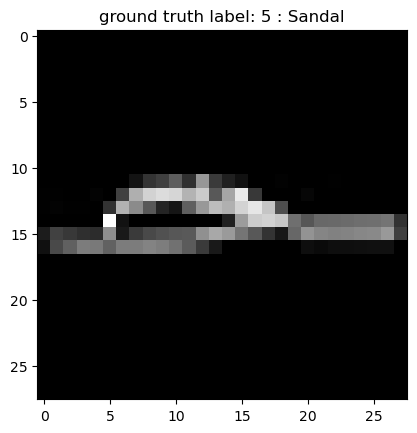

In [176]:
f = 8
test_img = validation_data[f][0][0]
test_img = test_img.reshape(test_img.shape[0], test_img.shape[1], 1)
test_img_label = validation_data[f][1]
plt.imshow(test_img, cmap='gray')
plt.title("ground truth label: " +str(test_img_label) + " : " + labels_dict[test_img_label])

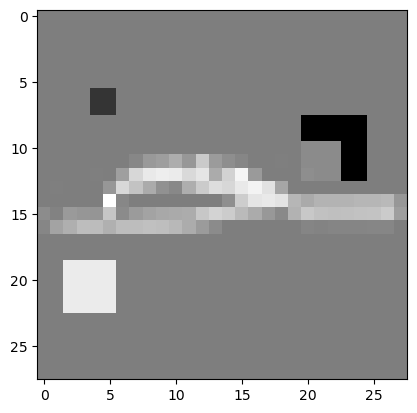

In [177]:
eps = 0.7
h = 10
w = test_img.shape[0]
c = 1
x_prime = test_img 
for i in range(7):
    x_prime += l_inf_P(eps, i, w, c)
plt.imshow(x_prime, cmap='gray')

In [178]:
pred = model_0(torch.tensor(x_prime).flatten())
label_pred = torch.argmax(pred)
print(labels_dict[int(label_pred.item())])

Sandal


/var/folders/47/kdzqfc9j7csfgrbl6qstjc780000gn/T/ipykernel_89269/2157850360.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = model_0(torch.tensor(x_prime).flatten())
